# Part 2
## 예제 2-1: 사람의 손글씨 데이터 MNIST 이용해 MLP 설계

* 설계하는 순서:
    1. 모듈 임포트
    2. 딥러닝 모델 설계 시 활용하는 장비 확인
    3. MNIST 데이터 다운(Train, Test 분리)
    4. 데이터 확인(1)
    5. 데이터 확인(2)
    6. MLP 모델 설계
    7. Optimizer, Objective Function 설정
    8. MLP 모델 학습 진행하면서 학습 데이터에 대한 모델 성능을 확인하는 함수 정의하기
    9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
    10. MLP 학습 실행하면서 Train, Test set의 Loss 및 Test set Accuracy 확인

In [3]:
"""
모듈 임포트
"""
import numpy as np
import matplotlib.pyplot as plt
import torch

# 신경망 모듈 설계 시 필요한 함수 모아둔 모듈
import torch.nn as nn

# torch.nn 모듈 중에서도 자주 이용되는 함수 F로 지정
import torch.nn.functional as F
from torchvision import transforms, datasets

In [4]:
"""
장비 확인
"""
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('using pytorch version: ', torch.__version__, 'device: ', DEVICE)

using pytorch version:  1.8.1 device:  cpu


In [5]:
BATCH_SIZE = 32
EPOCHS = 10

In [7]:
"""
MNIST 데이터 다운로드
"""
train_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = True,
                              download = True,
                              transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root="../data/MNIST",
                             train = False,
                             transform = transforms.ToTensor())

# 다운로드 한 데이터셋을 미니배치 단위로 분리해 지정
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = BATCH_SIZE,
                                         shuffle = False)


In [9]:
"""
데이터 확인: Mini-Batch 단위로 할당한 데이터 개수와 형태 확인
"""
for (X_train, y_train) in train_loader:
    print('X_train: ', X_train.size(), 'type: ', X_train.type())
    print('y_train: ', y_train.size(), 'type: ', y_train.type())
    break
    

X_train:  torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor


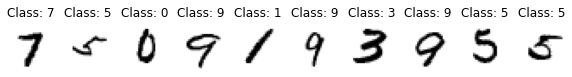

In [10]:
"""
데이터 확인: 데이터 그림 확인
"""
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [12]:
"""
MLP 모델 설계
"""
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        
        # view를 이용해 2차원 데이터를 1차원으로 변환(Flatten)
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        
        # 두번째 FF 레이어에 전달하기 위해 계산
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        
        return x

In [15]:
"""
Optimizer, Objective Function 설정
"""

# 모델을 device에 할당
model = Net().to(DEVICE)

# back propagation을 이용해 파라미터 업데이트 시 이용하는 optimizer 정의
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)

# loss 계산
criterion = nn.CrossEntropyLoss()

print(model)


Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [18]:
"""
MLP 모델 학습을 진행해 학습 데이터에 대한 모델 성능 확인하는 함수 정의
"""
def train(model, train_loader, optimizer, log_interval):
    model.train()
    
    # train_loader에는 미니배치 단위로 학습에 이용되는 (image, label)이 저장되어 있음. 
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        
        # 각 파라미터에 할당된 gradient 값을 이용해 파라미터 값 업데이트
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)] \t Train Loss: {:.6f}".format(Epoch, batch_idx * len(image),
                                                                                  len(train_loader.dataset), 
                                                                                  100. * batch_idx / len(train_loader), loss.item()))

In [23]:
"""
학습되는 과정 속에서 검증 데이터에 대한 모델 성능 확인하는 함수 정의
"""
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    # no_grad() 사용해 파라미터 업데이트 방지
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            
            test_loss += criterion(output, label).item()
            
            # 크기가 10인 벡터값 중 가장 큰 값에 대응하는 클래스로 예측했다고 판단
            prediction = output.max(1, keepdim = True)[1]
            
            # 올바르게 예측한 경우 count
            print("correct: ", prediction.eq(label.view_as(prediction)))
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    # 평균 loss 값 계산
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, test_accuracy

In [24]:
"""
학습 수행
"""
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:2f} %\n".format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000(0%)] 	 Train Loss: 1.232956
Train Epoch: 1 [6400/60000(11%)] 	 Train Loss: 1.311372
Train Epoch: 1 [12800/60000(21%)] 	 Train Loss: 1.051106
Train Epoch: 1 [19200/60000(32%)] 	 Train Loss: 1.142026
Train Epoch: 1 [25600/60000(43%)] 	 Train Loss: 1.410264
Train Epoch: 1 [32000/60000(53%)] 	 Train Loss: 0.972132
Train Epoch: 1 [38400/60000(64%)] 	 Train Loss: 1.138221
Train Epoch: 1 [44800/60000(75%)] 	 Train Loss: 0.725938
Train Epoch: 1 [51200/60000(85%)] 	 Train Loss: 0.935090
Train Epoch: 1 [57600/60000(96%)] 	 Train Loss: 0.746763
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
 

correct:  tensor([[False],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ 

correct:  tensor([[False],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [ True]])
correct:  tensor([[False],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ 

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ 

correct:  tensor([[ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ 

Train Epoch: 2 [6400/60000(11%)] 	 Train Loss: 0.896122
Train Epoch: 2 [12800/60000(21%)] 	 Train Loss: 0.808089
Train Epoch: 2 [19200/60000(32%)] 	 Train Loss: 0.599182
Train Epoch: 2 [25600/60000(43%)] 	 Train Loss: 0.539598
Train Epoch: 2 [32000/60000(53%)] 	 Train Loss: 0.825872
Train Epoch: 2 [38400/60000(64%)] 	 Train Loss: 0.780482
Train Epoch: 2 [44800/60000(75%)] 	 Train Loss: 0.546903
Train Epoch: 2 [51200/60000(85%)] 	 Train Loss: 0.601322
Train Epoch: 2 [57600/60000(96%)] 	 Train Loss: 0.884287
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
  

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [F

correct:  tensor([[ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ 

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[False],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ 

correct:  tensor([[False],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ 

Train Epoch: 3 [6400/60000(11%)] 	 Train Loss: 0.654161
Train Epoch: 3 [12800/60000(21%)] 	 Train Loss: 0.697345
Train Epoch: 3 [19200/60000(32%)] 	 Train Loss: 0.495579
Train Epoch: 3 [25600/60000(43%)] 	 Train Loss: 0.622853
Train Epoch: 3 [32000/60000(53%)] 	 Train Loss: 0.422003
Train Epoch: 3 [38400/60000(64%)] 	 Train Loss: 0.657678
Train Epoch: 3 [44800/60000(75%)] 	 Train Loss: 0.554023
Train Epoch: 3 [51200/60000(85%)] 	 Train Loss: 0.455635
Train Epoch: 3 [57600/60000(96%)] 	 Train Loss: 0.384052
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
  

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [F

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ 

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ 

Train Epoch: 4 [6400/60000(11%)] 	 Train Loss: 0.344755
Train Epoch: 4 [12800/60000(21%)] 	 Train Loss: 0.422360
Train Epoch: 4 [19200/60000(32%)] 	 Train Loss: 0.339893
Train Epoch: 4 [25600/60000(43%)] 	 Train Loss: 0.648481
Train Epoch: 4 [32000/60000(53%)] 	 Train Loss: 0.274138
Train Epoch: 4 [38400/60000(64%)] 	 Train Loss: 0.439217
Train Epoch: 4 [44800/60000(75%)] 	 Train Loss: 0.472451
Train Epoch: 4 [51200/60000(85%)] 	 Train Loss: 0.488711
Train Epoch: 4 [57600/60000(96%)] 	 Train Loss: 0.377914
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
  

correct:  tensor([[False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ 

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ 

correct:  tensor([[ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ 

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ 

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [F

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ 

correct:  tensor([[ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
   

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
   

Train Epoch: 6 [6400/60000(11%)] 	 Train Loss: 0.398389
Train Epoch: 6 [12800/60000(21%)] 	 Train Loss: 0.377928
Train Epoch: 6 [19200/60000(32%)] 	 Train Loss: 0.452828
Train Epoch: 6 [25600/60000(43%)] 	 Train Loss: 0.264649
Train Epoch: 6 [32000/60000(53%)] 	 Train Loss: 0.223785
Train Epoch: 6 [38400/60000(64%)] 	 Train Loss: 0.581071
Train Epoch: 6 [44800/60000(75%)] 	 Train Loss: 0.581591
Train Epoch: 6 [51200/60000(85%)] 	 Train Loss: 0.287135
Train Epoch: 6 [57600/60000(96%)] 	 Train Loss: 0.198515
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
  

correct:  tensor([[ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [F

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ 

correct:  tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ 

Train Epoch: 7 [6400/60000(11%)] 	 Train Loss: 0.296678
Train Epoch: 7 [12800/60000(21%)] 	 Train Loss: 0.388775
Train Epoch: 7 [19200/60000(32%)] 	 Train Loss: 0.382355
Train Epoch: 7 [25600/60000(43%)] 	 Train Loss: 0.394416
Train Epoch: 7 [32000/60000(53%)] 	 Train Loss: 0.238138
Train Epoch: 7 [38400/60000(64%)] 	 Train Loss: 0.342793
Train Epoch: 7 [44800/60000(75%)] 	 Train Loss: 0.736271
Train Epoch: 7 [51200/60000(85%)] 	 Train Loss: 0.176316
Train Epoch: 7 [57600/60000(96%)] 	 Train Loss: 0.320100
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
  

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ 

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ 

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ 

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ 

Train Epoch: 8 [6400/60000(11%)] 	 Train Loss: 0.271770
Train Epoch: 8 [12800/60000(21%)] 	 Train Loss: 0.291047
Train Epoch: 8 [19200/60000(32%)] 	 Train Loss: 0.284506
Train Epoch: 8 [25600/60000(43%)] 	 Train Loss: 0.212777
Train Epoch: 8 [32000/60000(53%)] 	 Train Loss: 0.427992
Train Epoch: 8 [38400/60000(64%)] 	 Train Loss: 0.224744
Train Epoch: 8 [44800/60000(75%)] 	 Train Loss: 0.265142
Train Epoch: 8 [51200/60000(85%)] 	 Train Loss: 0.487074
Train Epoch: 8 [57600/60000(96%)] 	 Train Loss: 0.339406
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
  

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ 

correct:  tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ 

Train Epoch: 9 [6400/60000(11%)] 	 Train Loss: 0.215896
Train Epoch: 9 [12800/60000(21%)] 	 Train Loss: 0.195221
Train Epoch: 9 [19200/60000(32%)] 	 Train Loss: 0.213641
Train Epoch: 9 [25600/60000(43%)] 	 Train Loss: 0.202884
Train Epoch: 9 [32000/60000(53%)] 	 Train Loss: 0.433500
Train Epoch: 9 [38400/60000(64%)] 	 Train Loss: 0.339748
Train Epoch: 9 [44800/60000(75%)] 	 Train Loss: 0.094757
Train Epoch: 9 [51200/60000(85%)] 	 Train Loss: 0.267417
Train Epoch: 9 [57600/60000(96%)] 	 Train Loss: 0.428210
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
  

correct:  tensor([[False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [F

correct:  tensor([[ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ 

correct:  tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [F

Train Epoch: 10 [6400/60000(11%)] 	 Train Loss: 0.185466
Train Epoch: 10 [12800/60000(21%)] 	 Train Loss: 0.525905
Train Epoch: 10 [19200/60000(32%)] 	 Train Loss: 0.410002
Train Epoch: 10 [25600/60000(43%)] 	 Train Loss: 0.186029
Train Epoch: 10 [32000/60000(53%)] 	 Train Loss: 0.160941
Train Epoch: 10 [38400/60000(64%)] 	 Train Loss: 0.226369
Train Epoch: 10 [44800/60000(75%)] 	 Train Loss: 0.213871
Train Epoch: 10 [51200/60000(85%)] 	 Train Loss: 0.088050
Train Epoch: 10 [57600/60000(96%)] 	 Train Loss: 0.127019
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ 

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True]])
correct:  tensor([[False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ 

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ 

correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ 

correct:  tensor([[False],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])
correct:  tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [ 